In [1]:
import pandas as pd

Predicting Boston Housing Prices. The BostonHousing.xlsx contains information collected by the US
Bureau of the Census concerning housing in the area of Boston, Massachusetts. The dataset includes
information on 506 census housing tracts in the Boston area. The goal is to predict the median house price
in new tracts based on information such as crime rate, pollution, and the number of rooms. The dataset
contains 13 predictors. CAT_MEDV is the outcome variable, showing if the median house price in the tract
is larger than 30 (MEDV>30). Drop MEDV from the dataset and solve it as a classification problem.
Split the dataset into training (60%) and test sets (40%) and answer the following questions (pass
random_state=1 to use the same pseudo-random number for splitting; this is for the reproducibility of the
code). Use 5-fold cross-validation for all cross-validation problems.

In [3]:
boston_df = pd.read_excel('BostonHousing.xlsx')
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CAT_MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,1
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,1
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,1


In [6]:
from sklearn.model_selection import train_test_split

outcome = 'CAT_MEDV'
predictors = boston_df.columns.drop([outcome,'MEDV']) # too much data points so drop zip
X = boston_df[predictors]
y = boston_df[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)


In [7]:
# 1. Is the dataset imbalanced?
boston_df['CAT_MEDV'].value_counts(normalize=True) 

# Yes, 83% of the data is cat less than 30 and only 17% of the data is cat greater than 30.

0    0.833992
1    0.166008
Name: CAT_MEDV, dtype: float64

In [8]:
# 2. Develop a Decision Tree to predict CAT_MEDV using all predictor variables and the following pruning
# settings: max_depth: 2 to 15, min_samples_split: 10 to 20, min_impurity_decrease: 0.0009, 0.001, and 0.0011. 
# Report the error on the training and test sets (pass random_state=1 when building the Tree).

from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV 

param_grid = {
    'max_depth': list(range(2,16)), # if best is the last val, rerun with new range
    'min_samples_split': list(range(10,21)),
    'min_impurity_decrease': [0.0009, 0.001, 0.0011] } 

gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1, scoring='accuracy') 
gridSearch.fit(train_X, train_y)
print('The best score: ', gridSearch.best_score_)
print('The best parameters: ', gridSearch.best_params_)

# getting the best Tree as a DecisionTreeClassifier object
bestTree = gridSearch.best_estimator_


The best score:  0.9275409836065573
The best parameters:  {'max_depth': 3, 'min_impurity_decrease': 0.0009, 'min_samples_split': 10}


In [11]:
# Report the error on the training and test sets
from dmba import classificationSummary

print('Training set:')
classificationSummary(train_y, bestTree.predict(train_X), class_names=bestTree.classes_)
print()
print('Test set:')
classificationSummary(valid_y, bestTree.predict(valid_X), class_names=bestTree.classes_)


Training set:
Confusion Matrix (Accuracy 0.9604)

       Prediction
Actual   0   1
     0 243   9
     1   3  48

Test set:
Confusion Matrix (Accuracy 0.9606)

       Prediction
Actual   0   1
     0 166   4
     1   4  29


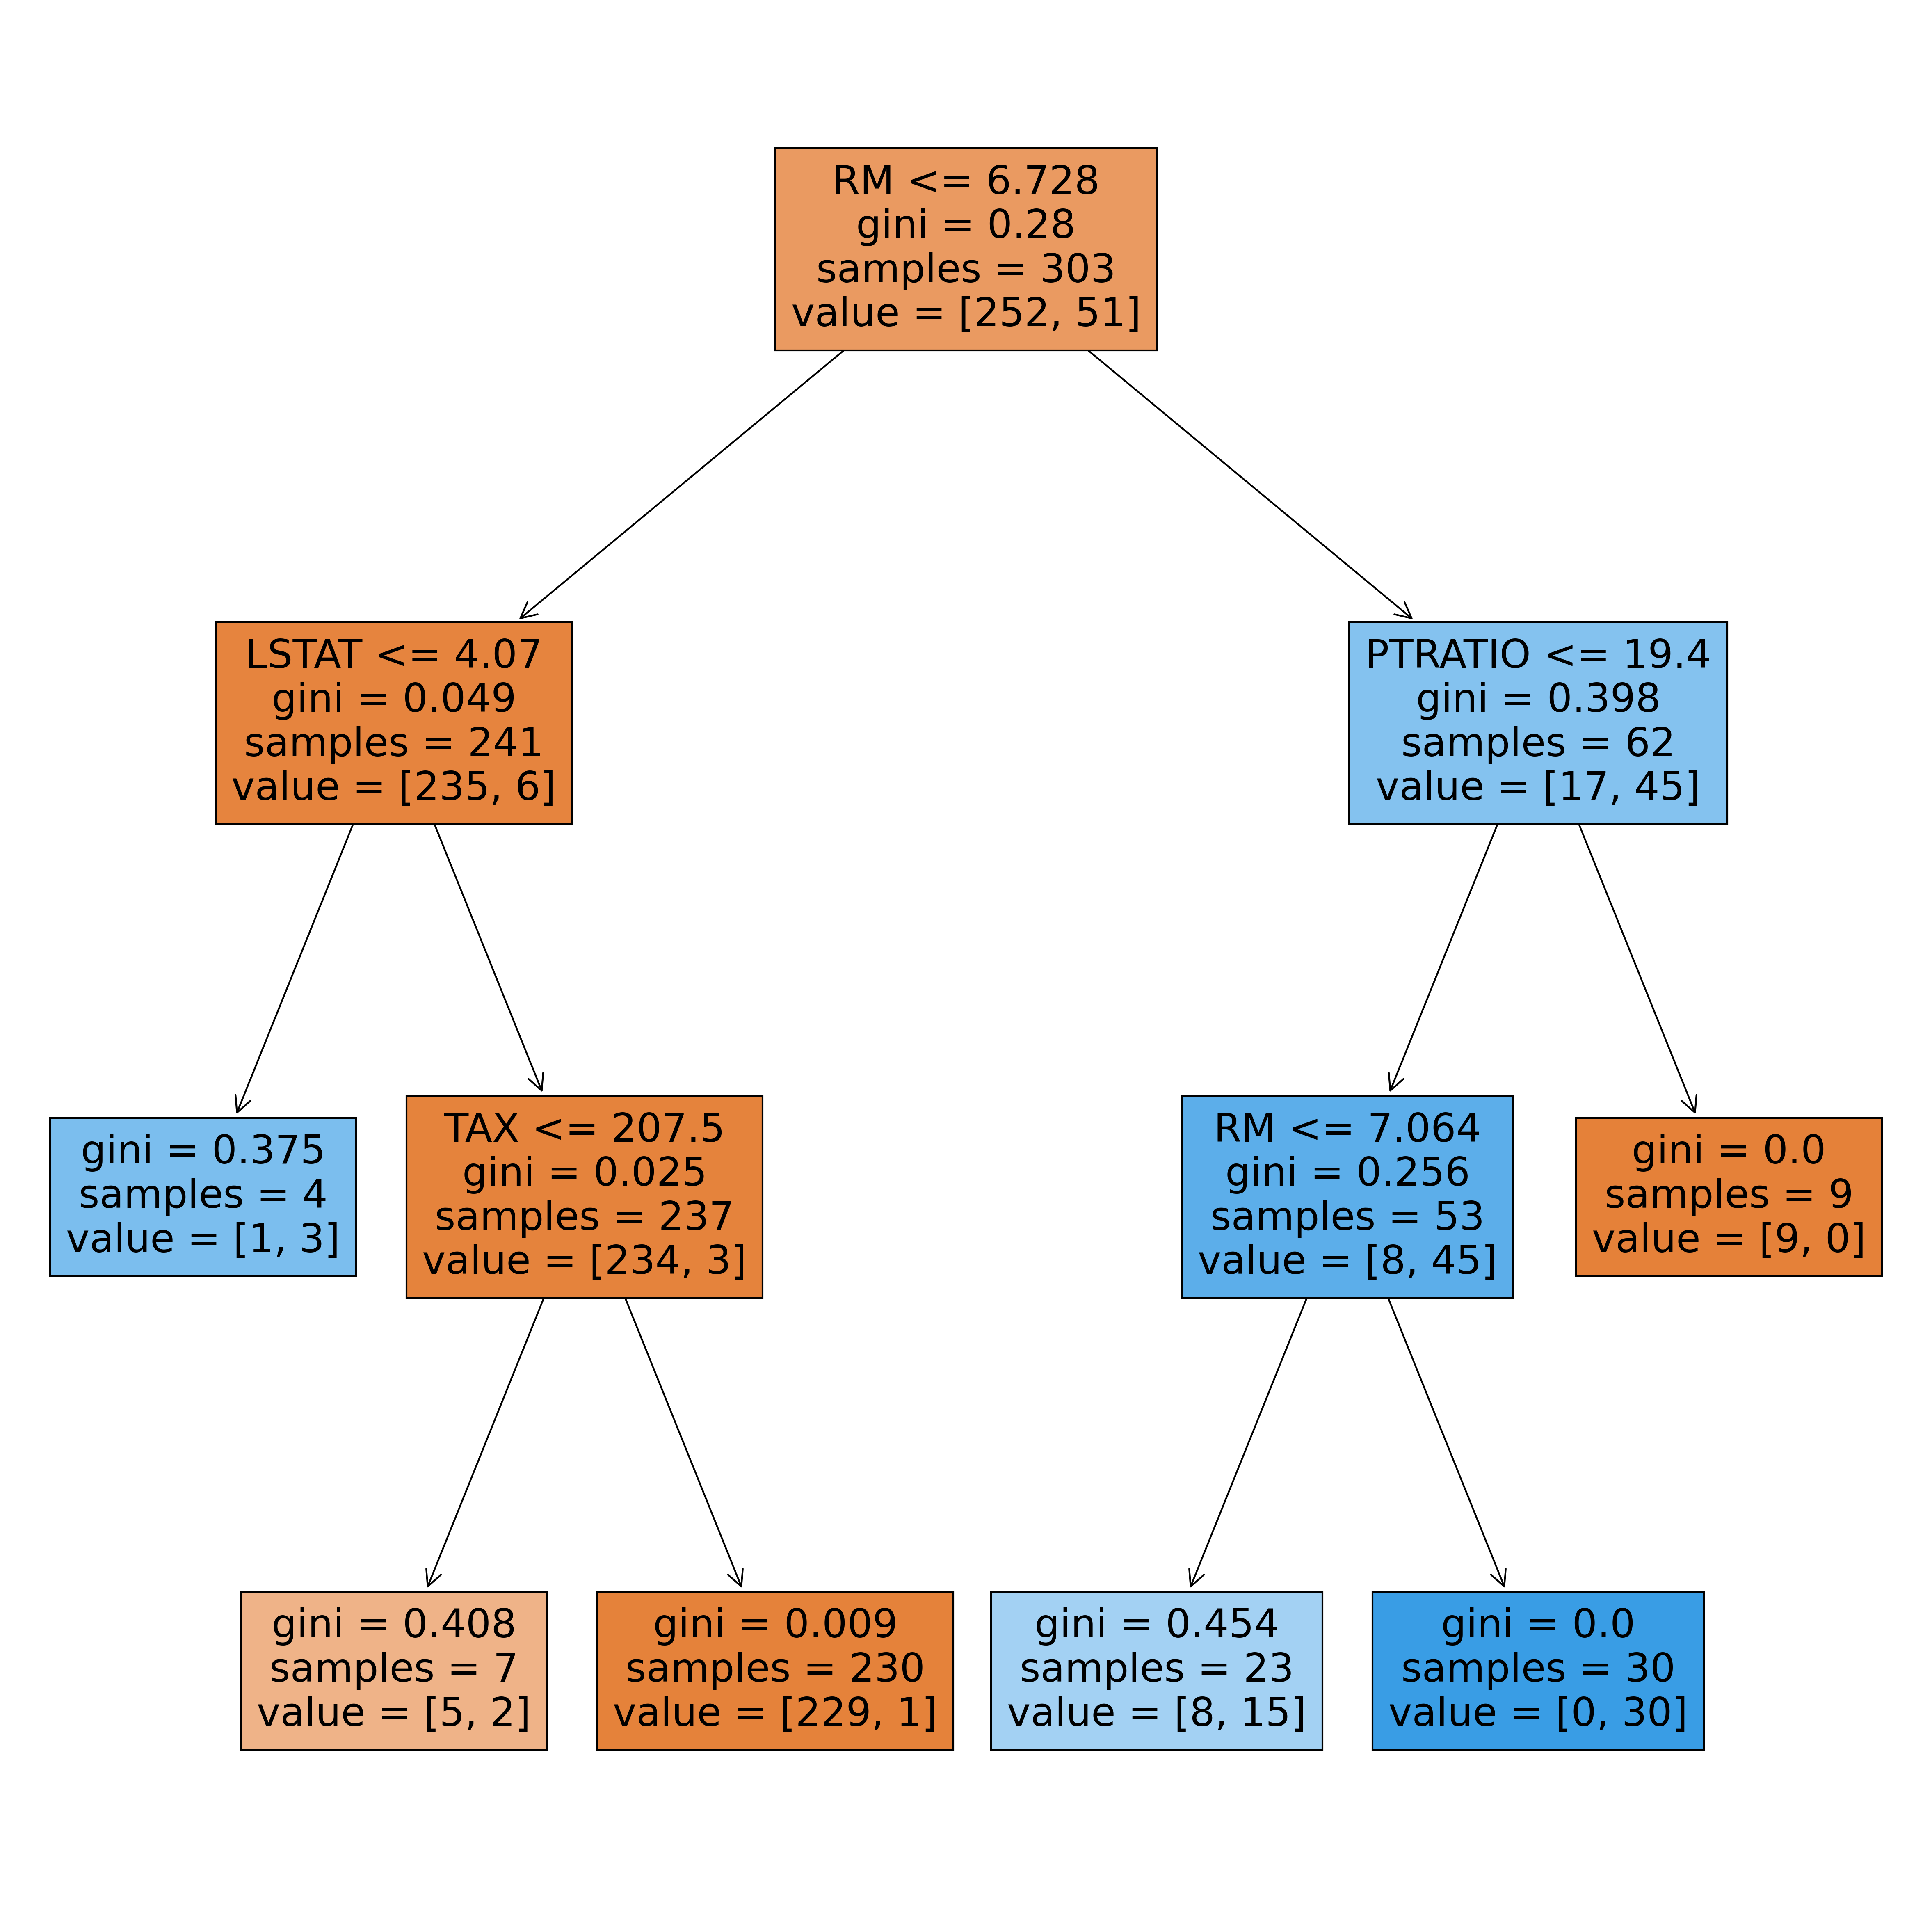

In [12]:
# a. Plot the best Tree.
from matplotlib import pyplot as plt
from sklearn import tree
%matplotlib inline 

fig = plt.figure(figsize=(20,20),dpi=300)
_=tree.plot_tree(bestTree, 
                   feature_names=train_X.columns,  
                   filled=True)
fig.savefig("best_tree.png")
plt.show()


In [13]:
# b. How many nodes does the chosen Tree have?
print('Number of nodes', bestTree.tree_.node_count)


Number of nodes 11


In [14]:
# c. Show the variable importance in descending order.
pd.DataFrame({'Predictor':train_X.columns, 'Importance':bestTree.feature_importances_}).sort_values(by='Importance', ascending=False)


,Predictor,Importance
5,RM,0.758329
10,PTRATIO,0.163009
12,LSTAT,0.062855
9,TAX,0.015806
0,CRIM,0.000000
1,ZN,0.000000
2,INDUS,0.000000
3,CHAS,0.000000
4,NOX,0.000000
6,AGE,0.000000


In [16]:
# 3. Assume that the cost of misclassification is not the same for all classes and we would like to increase
# the accuracy of the model on class 1. Impose a penalty on class weights based on the number of records
# per class label and fit the model you developed in problem 2 again. Produce the confusion matrix for
# both training and test sets. 

param_grid = {
    'max_depth': list(range(2,16)), # if best is the last val, rerun with new range
    'min_samples_split': list(range(10,21)),
    'min_impurity_decrease': [0.0009, 0.001, 0.0011] } 

gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1, class_weight='balanced'), param_grid, cv=5, n_jobs=-1, scoring='accuracy') 
gridSearch.fit(train_X, train_y)
print('The best score: ', gridSearch.best_score_)
print('The best parameters: ', gridSearch.best_params_)

# getting the best Tree as a DecisionTreeClassifier object
bestTree = gridSearch.best_estimator_


The best score:  0.9112021857923498
The best parameters:  {'max_depth': 3, 'min_impurity_decrease': 0.0009, 'min_samples_split': 10}


In [17]:
print('Training set:')
classificationSummary(train_y, bestTree.predict(train_X), class_names=bestTree.classes_)
print()
print('Test set:')
classificationSummary(valid_y, bestTree.predict(valid_X), class_names=bestTree.classes_)


Training set:
Confusion Matrix (Accuracy 0.9505)

       Prediction
Actual   0   1
     0 238  14
     1   1  50

Test set:
Confusion Matrix (Accuracy 0.9310)

       Prediction
Actual   0   1
     0 159  11
     1   3  30


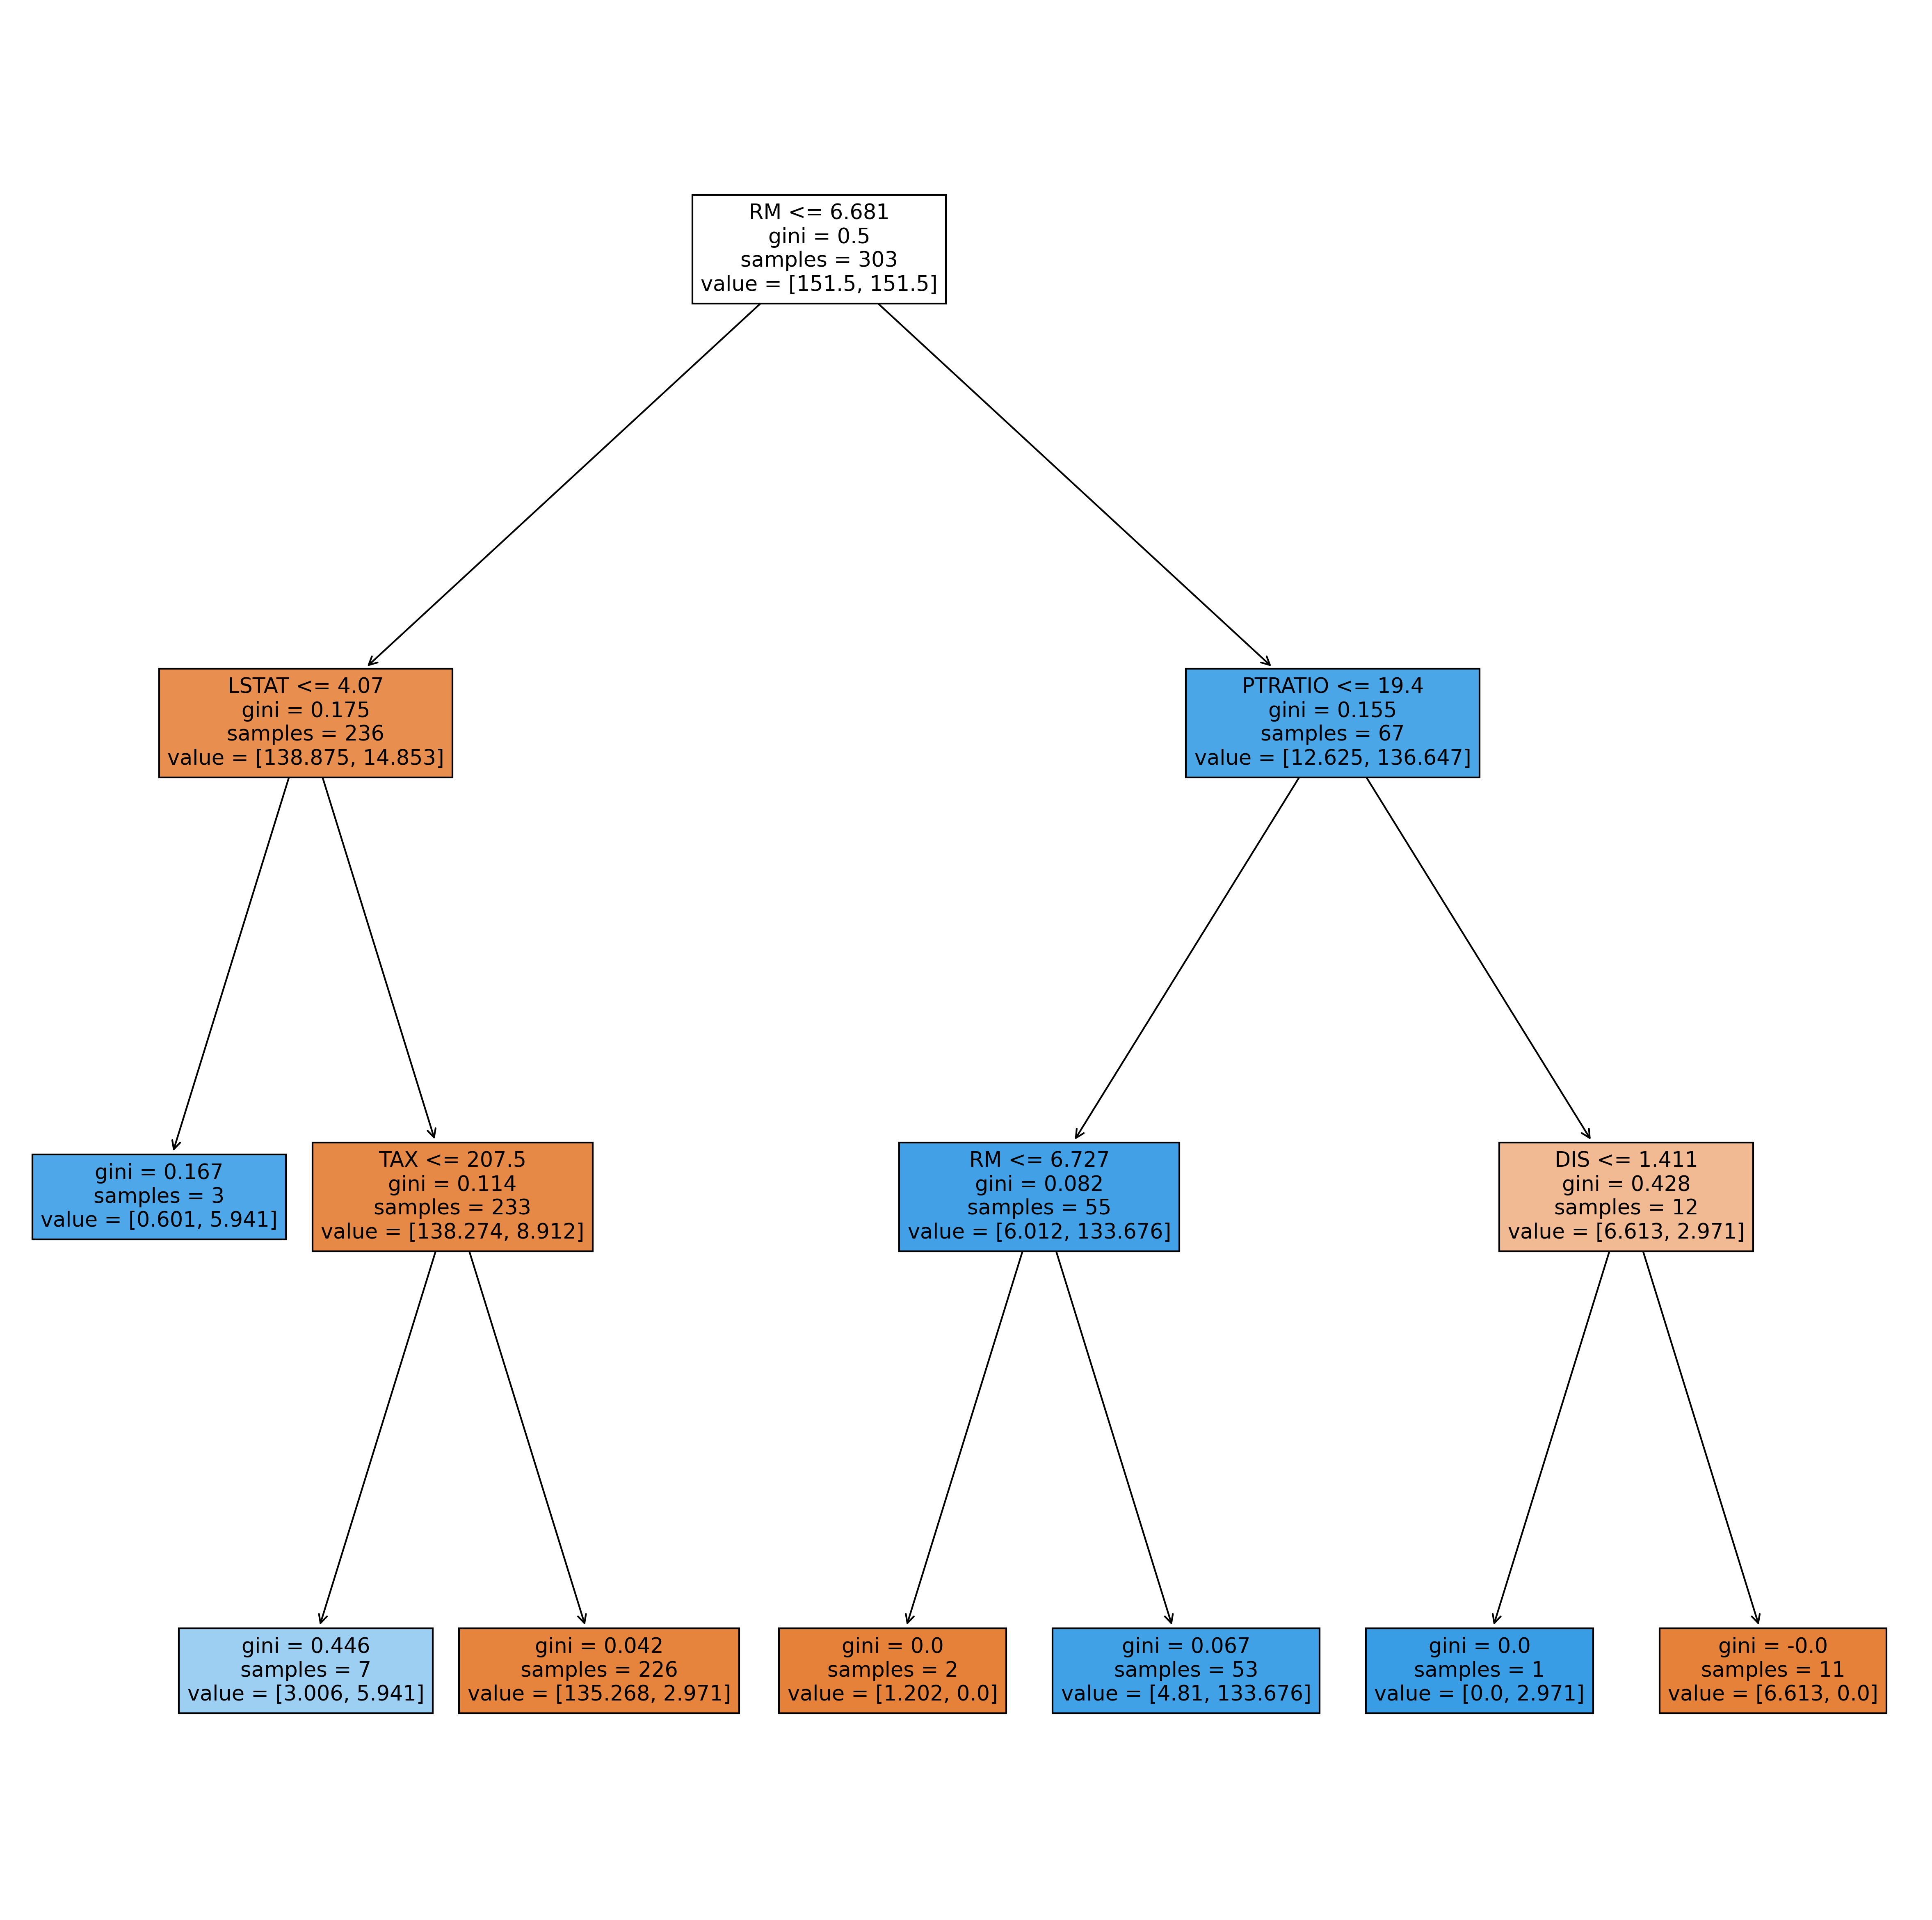

In [18]:
from matplotlib import pyplot as plt
from sklearn import tree
%matplotlib inline 

fig = plt.figure(figsize=(20,20),dpi=300)
_=tree.plot_tree(bestTree, 
                   feature_names=train_X.columns,  
                   filled=True)
fig.savefig("best_tree.png")
plt.show()


In [19]:
print('Number of nodes', bestTree.tree_.node_count)


Number of nodes 13


In [20]:
pd.DataFrame({'Predictor':train_X.columns, 'Importance':bestTree.feature_importances_}).sort_values(by='Importance', ascending=False)


,Predictor,Importance
5,RM,0.790231
12,LSTAT,0.068532
10,PTRATIO,0.057178
9,TAX,0.052839
7,DIS,0.031219
0,CRIM,0.000000
1,ZN,0.000000
2,INDUS,0.000000
3,CHAS,0.000000
4,NOX,0.000000


Predicting house prices in King County. The kc_house_data.xlsx dataset shows the sold price of 21,613
houses in King County in 2014-2015. The dataset contains 21 columns. The ‘price’ column shows the
sold price and is the target variable for predictive modeling. Use the following predictor variables to
answer problems 4-5: bedrooms, bathrooms, sqft_lot, floors, waterfront, view, condition, grade,
sqft_above, sqft_basement, yr_built, yr_renovated, zipcode. To answer the questions, transform only nominal categorical variables and split the dataset into training (60%) and test sets (40%). For all cross-
validation processes, use 5-fold cross-validation.

In [21]:
kc_df = pd.read_excel('kc_house_data.xlsx')
kc_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [29]:
outcome='price'
predictors=['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode']

X = pd.get_dummies(kc_df[predictors], columns=['zipcode',], drop_first=True)
y = kc_df[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [30]:
# 4. Develop a Decision Tree to predict the price of a house using the following pruning settings:
# max_depth: 10 to 15, min_samples_split: 15 to 20, min_impurity_decrease: 0.0009, 0.001, and 0.0011.
# pick the best model using MAE. Report the error on the training and test sets. 

from sklearn.tree import DecisionTreeRegressor

param_grid = {
    'max_depth': list(range(10, 16)), 
    'min_samples_split': list(range(15, 21)), 
    'min_impurity_decrease': [0.0009, 0.001, 0.0011],}

gridSearch = GridSearchCV(DecisionTreeRegressor(random_state=1), param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error') # cv=10 is most common
gridSearch.fit(train_X, train_y)
print('Best score: ', gridSearch.best_score_)
print('Best parameters: ', gridSearch.best_params_)

bestTree = gridSearch.best_estimator_


Best score:  -119761.0071575259
Best parameters:  {'max_depth': 15, 'min_impurity_decrease': 0.0009, 'min_samples_split': 20}


In [31]:
# Report the error on the training and test sets.
from dmba import regressionSummary 

print('Training set:')
regressionSummary(train_y, bestTree.predict(train_X))
print()
print('Test set:')
regressionSummary(valid_y, bestTree.predict(valid_X))


Training set:

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 139605.3735
            Mean Absolute Error (MAE) : 90811.8425
          Mean Percentage Error (MPE) : -5.8274
Mean Absolute Percentage Error (MAPE) : 19.2829

Test set:

Regression statistics

                      Mean Error (ME) : 1385.6515
       Root Mean Squared Error (RMSE) : 207761.7589
            Mean Absolute Error (MAE) : 119331.9612
          Mean Percentage Error (MPE) : -7.4854
Mean Absolute Percentage Error (MAPE) : 23.3469


In [28]:
# 5. Using the model you obtained in problem 4, find the top five important variables?

pd.DataFrame({'Predictor': train_X.columns, 'importance': bestTree.feature_importances_}).sort_values(by='importance', ascending=False).head(5)


,Predictor,importance
7,grade,0.596617
10,yr_built,0.097696
1,bathrooms,0.048657
8,sqft_above,0.040016
14,zipcode_98004,0.039327
